# 推理引擎ONNX Runtime部署-预测摄像头实时画面-英文

使用 ONNX Runtime 推理引擎，载入 ImageNet 预训练图像分类 onnx 模型，预测摄像头实时画面。

同济子豪兄：https://space.bilibili.com/1900783

测试运行环境：Macbook Pro

## 注意事项

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

在本地运行
```
pip install onnxruntime
```

安装onnx runtime，并准备好onnx模型文件。

## 导入工具包

In [16]:
import cv2
import time

import onnxruntime
import torch

import pandas as pd
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [4]:
ort_session = onnxruntime.InferenceSession('resnet18_imagenet.onnx')

## 载入ImageNet 1000图像分类标签

In [5]:
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']

In [7]:
# idx_to_labels

## 图像预处理

In [8]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 预测摄像头单帧画面

### 调用摄像头获取一帧画面

In [18]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(3) # 运行本代码后等几秒拍照

# 从摄像头捕获一帧画面
success, img_bgr = cap.read()

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [42]:
img_bgr.shape

(720, 1280, 3)

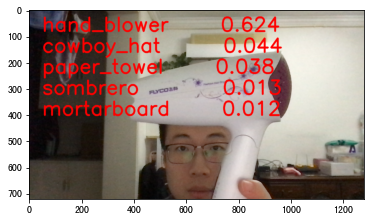

In [43]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

### 画面转成 RGB 的 Pillow 格式

In [22]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [23]:
img_pil = Image.fromarray(img_rgb)

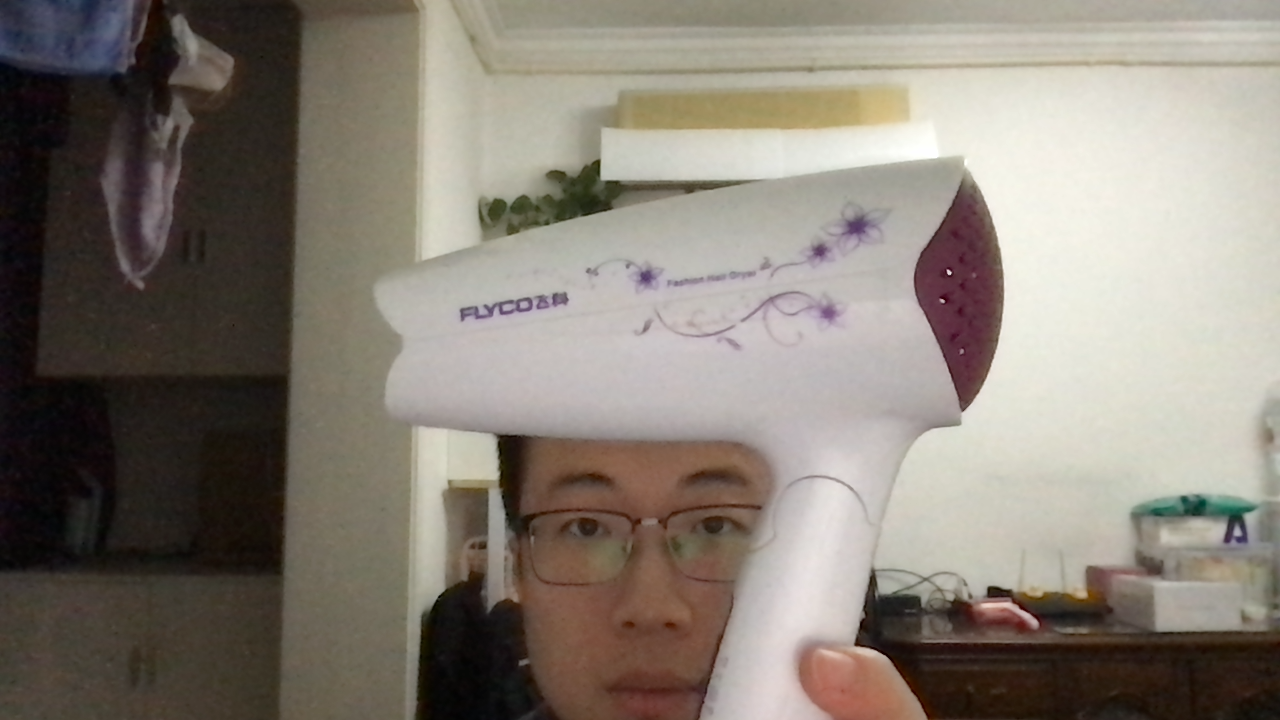

In [24]:
img_pil

### 预处理

In [25]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

In [26]:
input_tensor.shape

(1, 3, 256, 256)

### ONNX Runtime推理预测

In [28]:
# onnx runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [29]:
pred_logits.shape

torch.Size([1, 1000])

### 获得预测结果

In [30]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [31]:
pred_softmax.shape

torch.Size([1, 1000])

### 解析top-n预测结果的类别和置信度

In [32]:
n = 5
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果

In [33]:
confs = top_n[0].cpu().detach().numpy().squeeze()

In [34]:
confs

array([0.62411743, 0.04395951, 0.03787332, 0.01333915, 0.01210907],
      dtype=float32)

In [35]:
pred_ids = top_n[1].cpu().detach().numpy().squeeze()

In [36]:
pred_ids

array([589, 515, 700, 808, 667])

### 在图像上写英文

In [37]:
for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    
    # 写字：图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, text, (50, 80 + 80 * i), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 255), 5, cv2.LINE_AA)
    

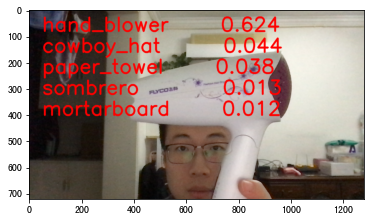

In [45]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 处理单帧画面的函数（英文）

In [46]:
# 处理帧函数
def process_frame(img_bgr):
    
    '''
    输入摄像头拍摄画面bgr-array，输出图像分类预测结果bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    ## 画面转成 RGB 的 Pillow 格式
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL
    
    ## 预处理
    input_img = test_transform(img_pil) # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ## onnx runtime 预测
    ort_inputs = {'input': input_tensor} # onnx runtime 输入
    pred_logits = ort_session.run(['output'], ort_inputs)[0] # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    ## 解析top-n预测结果的类别和置信度
    top_n = torch.topk(pred_softmax, 5) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析预测类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析置信度
    
    # 在图像上写英文
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        
        # 写字：图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
        img_bgr = cv2.putText(img_bgr, text, (50, 160 + 80 * i), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)

    return img_bgr

## 调用摄像头获取每帧（模板）

In [47]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()